## The Scaling of Modern SAT Solvers on Random 3-SAT Problems
-----------

## Imports


In [1]:
import random
import time
import itertools
import numpy as np
import os
import numpy as np
import json
from tqdm import tqdm
from pysat.solvers import Glucose42, Minicard,Lingeling, Cadical153, Minisat22,MapleChrono, Mergesat3
os.chdir('..') if os.path.split(os.getcwd())[-1] != 'ExploringKSAT' else None
print(os.getcwd()) # Should be ...\ExploringKSAT

from Code.generators import KSAT_Generator
from Code.solvers import brute_force, DPLL, BruteForce

C:\Users\shairozs\Documents\Projects\EasySAT


## Hyperparameters


In [2]:
MAX_LITERALS = 20 # Total number of literals to check up to
TRIALS_PER_LITERAL = 50 # Number of trials for each literal

MAX_BFS_LITERALS = 15 # Do not evaluate BFS beyond this # of literals
MAX_DPLL_LITERALS = 20 # Do not evaluate DPLL beyond this # of literals

## Evaluation Loop

In [5]:
ksg = KSAT_Generator()
literals = list(range(3,MAX_LITERALS))
brute_force_times = []
dpll_times = []
glucose_times = []
cadical_times = []
ms_times = []
lg_times = []
maple_times = []



hardest_problem = {}

for num_literals in tqdm(literals, total = len(literals)):
    
    _brute_force_times = []
    _dpll_times = []
    _glucose_times = []
    _cadical_times = []
    _ms_times = []
    _lg_times = []
    _maple_times = []

    #print(b)
    for num_conjuncts in [np.random.randint(num_literals*4,num_literals*5) for i in range(trials)]:

        # Sample a random 3SAT clause
        sample_cnf = ksg.random_kcnf(n_literals = num_literals, n_conjuncts=num_conjuncts)
        
        # Initialize solver
        g = Glucose42()#warm_start = True)
        c = Minicard()
        ms = Lingeling()
        maple = Mergesat3()
        dpll = DPLL()
        bfs = BruteForce()
        
        
        g.append_formula(sample_cnf)
        c.append_formula(sample_cnf)
        ms.append_formula(sample_cnf)
        maple.append_formula(sample_cnf)
        bfs.append_formula(sample_cnf)
        dpll.append_formula(sample_cnf)
        
        ## Run BFS
        if num_literals <= MAX_BFS_LITERALS:
            start = time.time()
            _,_, assigns = bfs.solve()
            runtime = time.time() - start
            _brute_force_times.append(assigns)
            #_brute_force_times.append(runtime)
        
        ## Run DPLL
        if num_literals <= MAX_DPLL_LITERALS:
            start = time.time()
            _,answer,assigns = dpll.solve()
            runtime = time.time() - start
            _dpll_times.append(assigns)
            #_dpll_times.append(runtime)
        
        
        ## Run Glucose
        start = time.time()
        result = g.solve()
        runtime = time.time() - start
        _glucose_times.append(g.accum_stats()['propagations'])
        #_glucose_times.append(runtime)
        
        props = g.accum_stats()['propagations']
        if num_literals not in hardest_problem.keys():
            hardest_problem[num_literals] = (sample_cnf, props, result, answer)
        elif hardest_problem[num_literals][1] < props:
            hardest_problem[num_literals] = (sample_cnf, props, result, answer)
            

        ## Run Cadical
        start = time.time()
        c.solve()
        runtime = time.time() - start
        _cadical_times.append(c.accum_stats()['propagations'])
        #_cadical_times.append(runtime)
        
        ## Run Minisat
        start = time.time()
        ms.solve()
        runtime = time.time() - start
        _ms_times.append(ms.accum_stats()['propagations'])
        #_ms_times.append(runtime)
        
        ## Run Maple
        start = time.time()
        maple.solve()
        runtime = time.time() - start
        _maple_times.append(maple.accum_stats()['propagations'])
        #_maple_times.append(runtime)
    
    if num_literals <= MAX_BFS_LITERALS:
        brute_force_times.append(np.max(_brute_force_times))
    if num_literals <= MAX_DPLL_LITERALS:
        dpll_times.append(np.max(_dpll_times))
        
    glucose_times.append(np.max(_glucose_times))
    cadical_times.append(np.max(_cadical_times))
    ms_times.append(np.max(_ms_times))
    maple_times.append(np.max(_maple_times))

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [11:28<00:00, 40.51s/it]


## Plotting Results


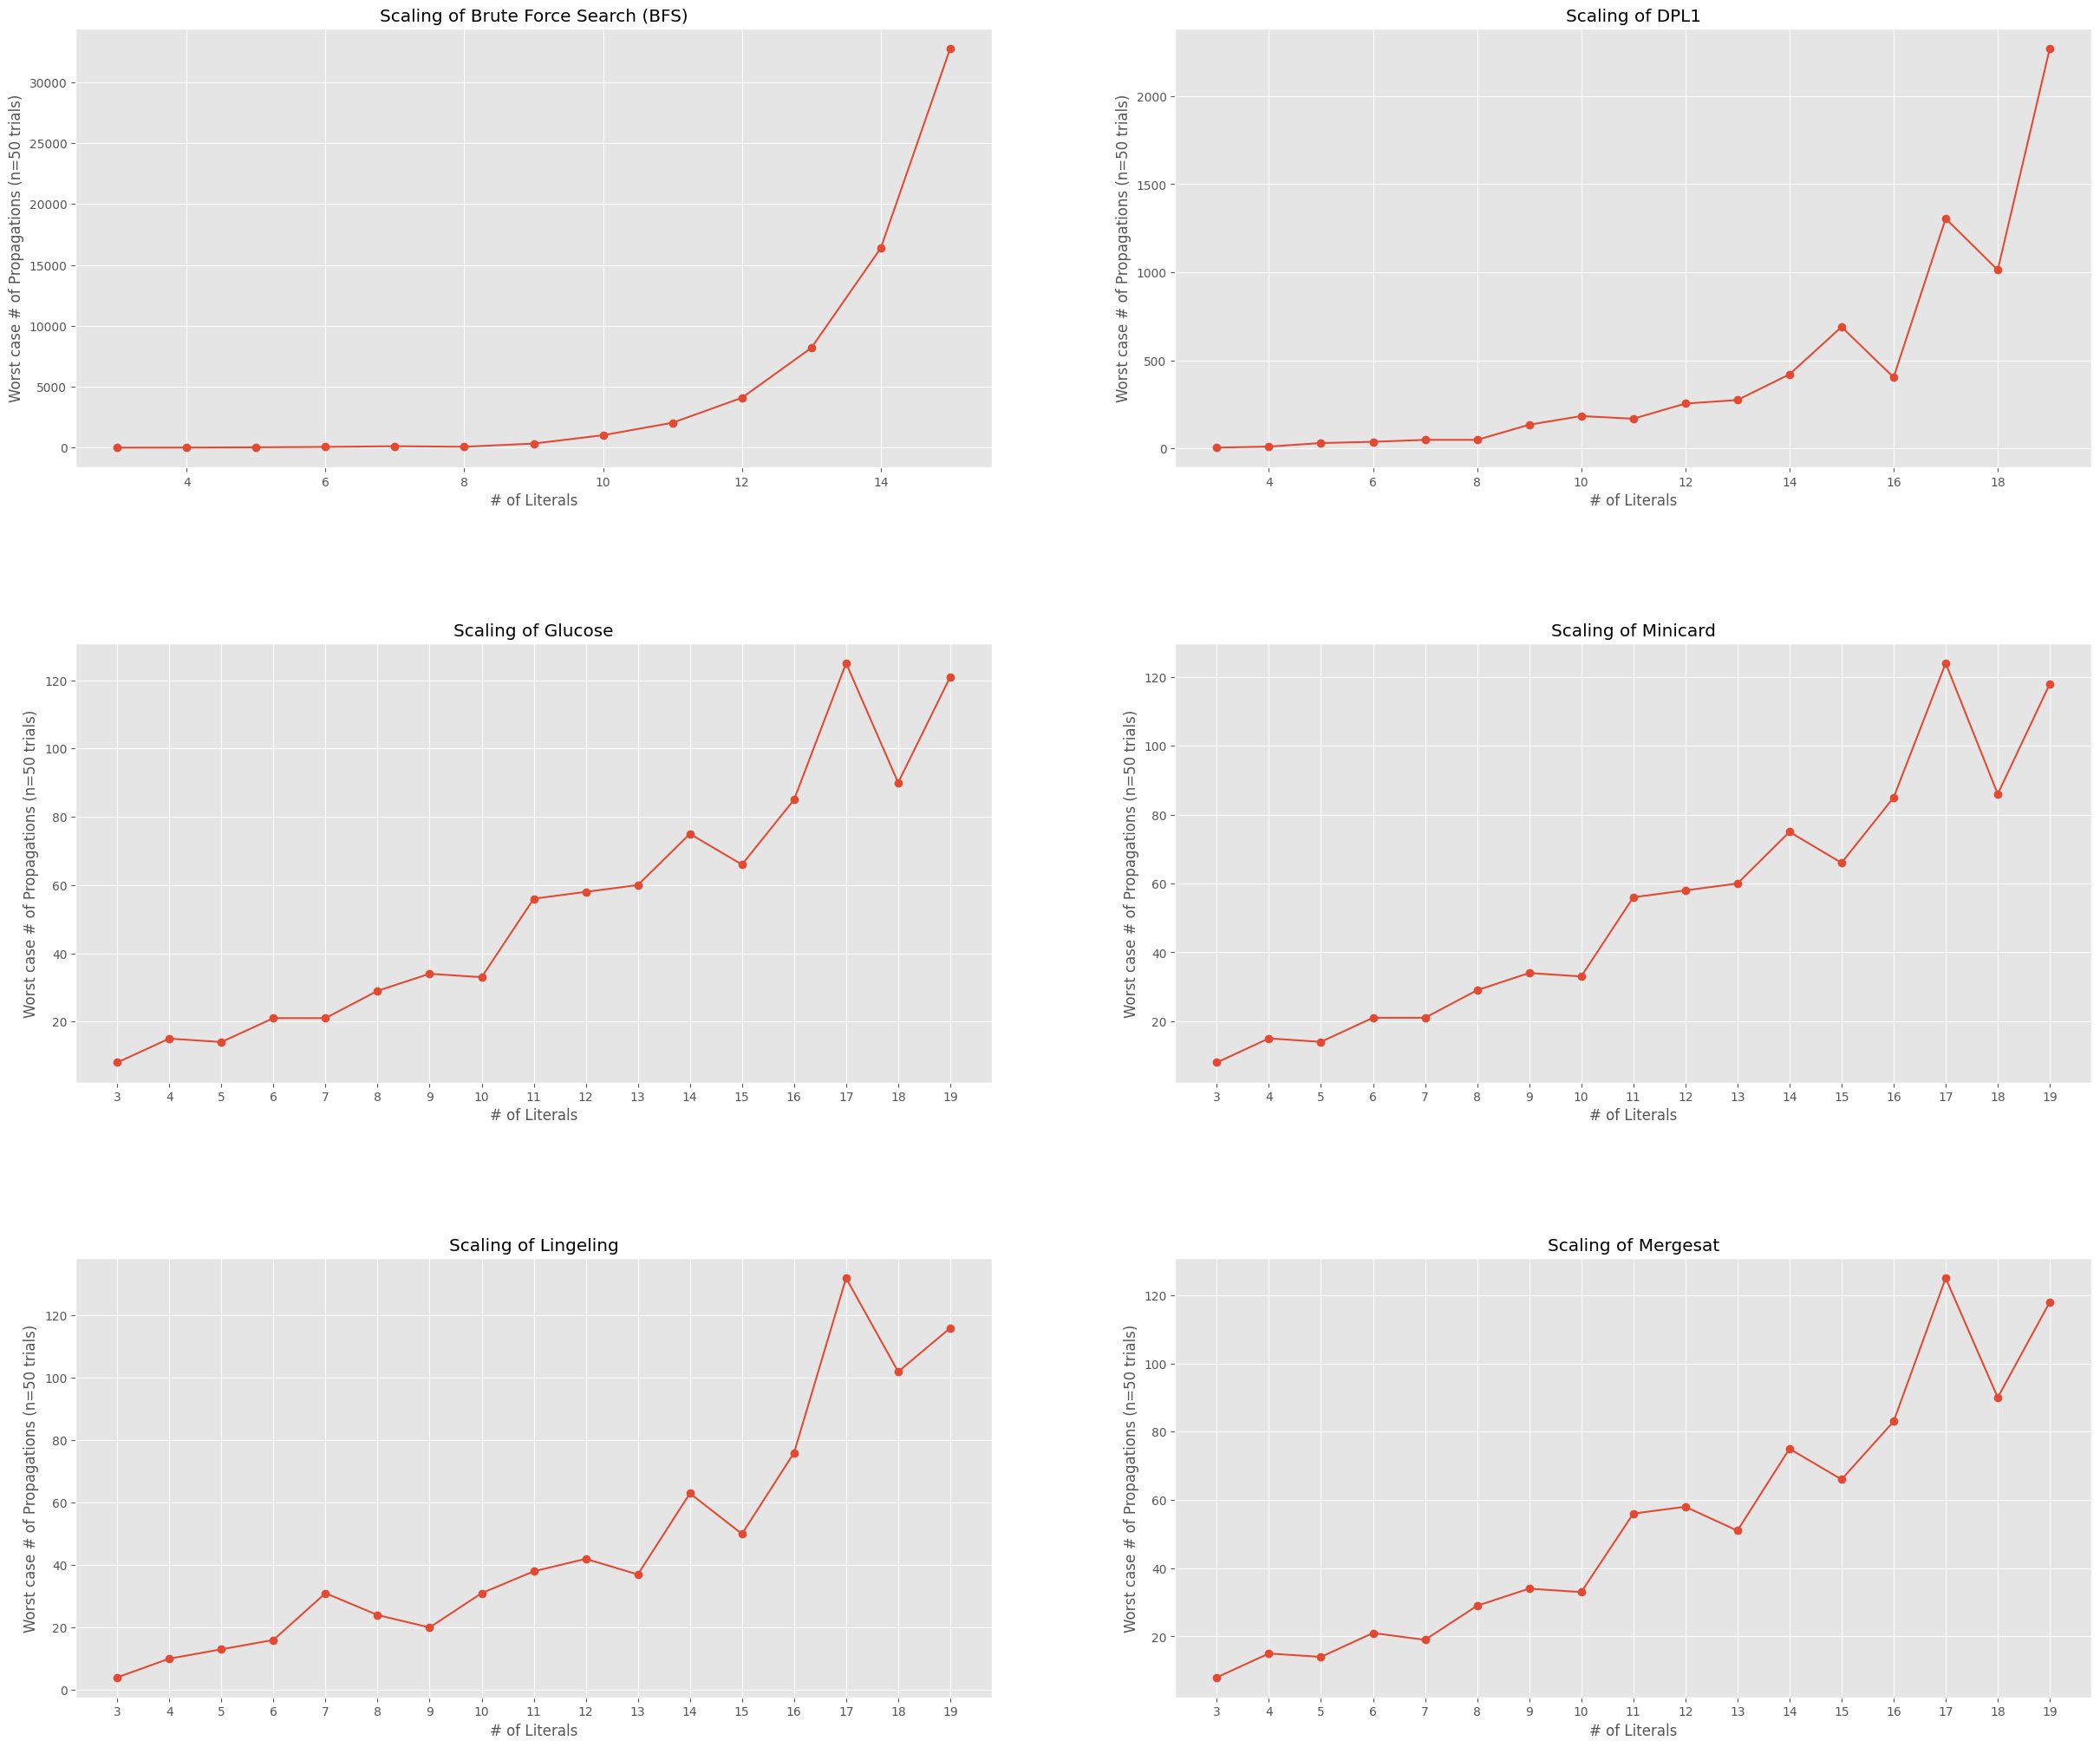

In [6]:
import matplotlib.pyplot as plt


plt.style.use('ggplot')

fig, axes = plt.subplots(3,2, figsize = (30,25))
a = 3; SOLVER = 'Glucose'

axes[0,0].plot(literals[:len(brute_force_times)], brute_force_times[:MAX_LITERALS], 'o-', label = "BFS Iterations")
axes[1,0].set_xticks(literals[:len(brute_force_times)])
#axes[0,0].plot([2**x for x in range(len(brute_force_times))], alpha = 0.8, linestyle = '--')

axes[0,1].plot(literals[:len(dpll_times)], dpll_times, 'o-',  label = "DPLL Iterations")
axes[1,0].set_xticks(literals[:len(dpll_times)])
#axes[0,1].plot([1.2**x for x in range(len(dpll_times))], alpha = 0.8, linestyle = '--')

axes[1,0].plot(literals, glucose_times,  'o-')
axes[1,0].set_xticks(literals)
#axes[1,0].plot([1.2**x for x in range(len(glucose_times))], alpha = 0.8, linestyle = '--')

axes[1,1].plot(literals, cadical_times, 'o-')
axes[1,1].set_xticks(literals)
#axes[1,1].plot([1.2**x for x in range(len(cadical_times))], alpha = 0.8, linestyle = '--')

axes[2,0].plot(literals, ms_times, 'o-')
axes[2,0].set_xticks(literals)

#axes[2,0].plot([1.2**x for x in range(len(ms_times))], alpha = 0.8, linestyle = '--')

axes[2,1].plot(literals, maple_times, 'o-')
axes[2,1].set_xticks(literals)

#axes[2,1].plot([1.2**x for x in range(len(maple_times))], alpha = 0.8, linestyle = '--')


#axes[0,0].yaxis.set_ticklabels([]);
axes[0,0].set_title("Scaling of Brute Force Search (BFS)")
#axes[0,1].yaxis.set_ticklabels([]);
axes[0,1].set_title("Scaling of DPL1")
#axes[1,0].yaxis.set_ticklabels([]); 
axes[1,0].set_title("Scaling of Glucose")
#axes[1,1].yaxis.set_ticklabels([]); 
axes[1,1].set_title("Scaling of Minicard")
axes[2,0].set_title("Scaling of Lingeling")
axes[2,1].set_title("Scaling of Mergesat")

axes[0,0].set_ylabel("Worst case # of Propagations (n=50 trials)")
axes[0,1].set_ylabel("Worst case # of Propagations (n=50 trials)")
axes[1,0].set_ylabel("Worst case # of Propagations (n=50 trials)")
axes[1,1].set_ylabel("Worst case # of Propagations (n=50 trials)")
axes[2,0].set_ylabel("Worst case # of Propagations (n=50 trials)")
axes[2,1].set_ylabel("Worst case # of Propagations (n=50 trials)")

axes[0,0].set_xlabel("# of Literals")
axes[0,1].set_xlabel("# of Literals")
axes[1,0].set_xlabel("# of Literals")
axes[1,1].set_xlabel("# of Literals")
axes[2,0].set_xlabel("# of Literals")
axes[2,1].set_xlabel("# of Literals")


fig.subplots_adjust(hspace = 0.4)
#axes.scatter([x[0] for x in points], [x[1] for x in points])
#axes.set_title("Evaluation of " + str(a) + "-SAT problems using " + SOLVER)
#axes.set_xlabel("Number of Conjuncts")
#axes.set_ylabel("Time (seconds)")

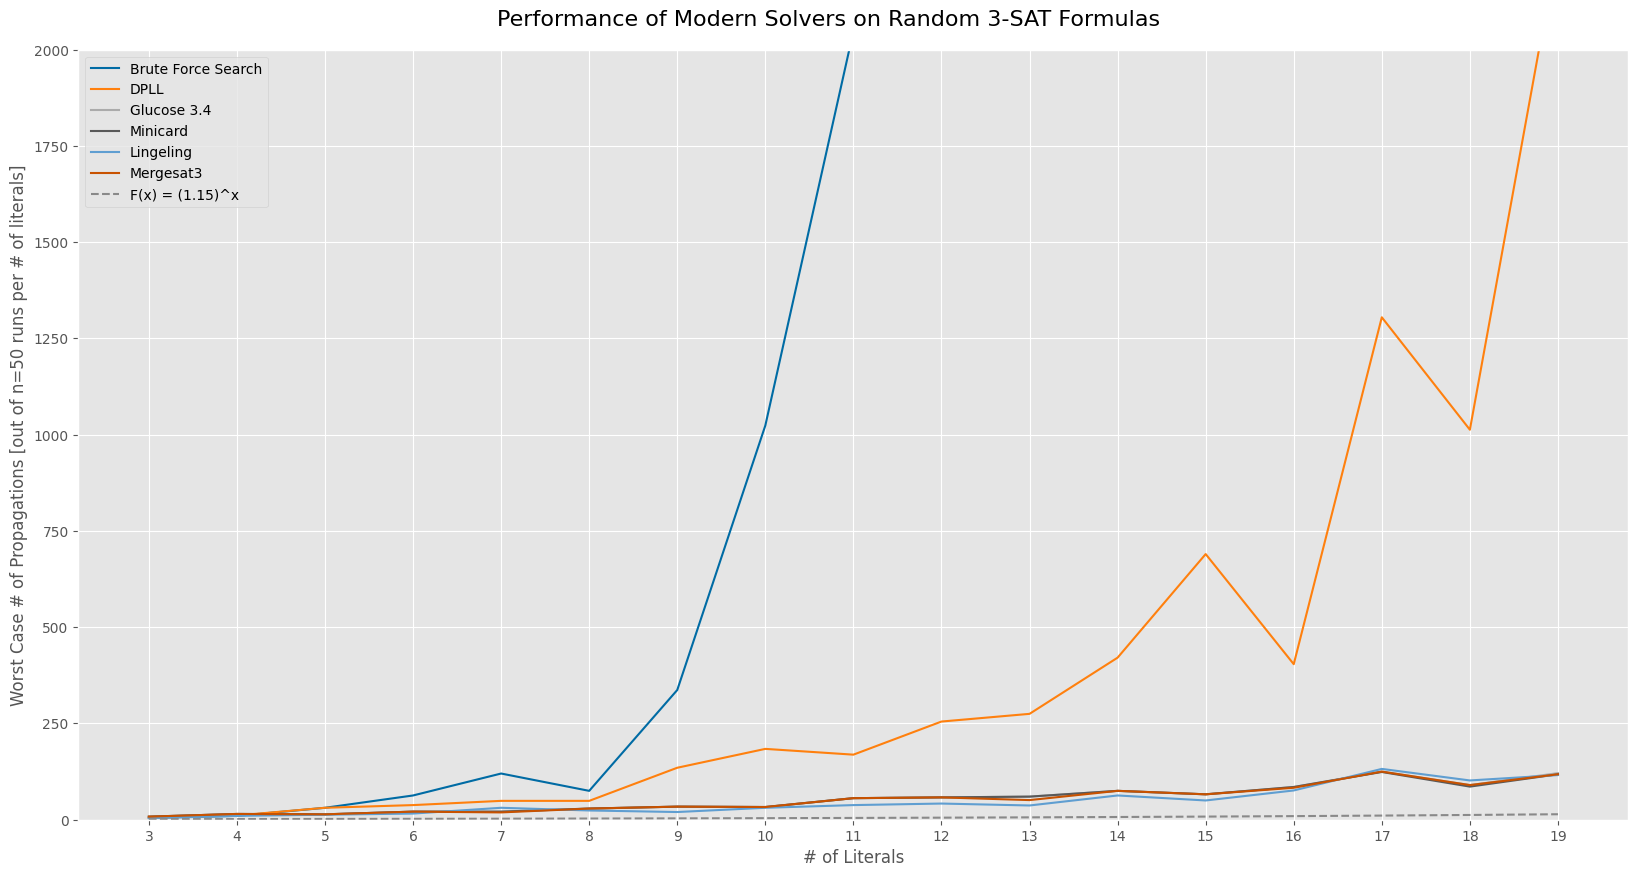

In [7]:
plt.style.use('tableau-colorblind10')
fig, axes = plt.subplots(figsize = (20,10))

axes.plot(literals[:len(brute_force_times)], brute_force_times, label = "Brute Force Search")
axes.plot(literals[:len(dpll_times)], dpll_times, label = "DPLL")
axes.plot(literals[:len(glucose_times)], glucose_times, label = "Glucose 3.4")
axes.plot(literals, cadical_times, label = "Minicard")
axes.plot(literals, ms_times, label = "Lingeling")
axes.plot(literals, maple_times, label = "Mergesat3")
axes.plot(literals, [1.15**n for n in literals], linestyle = '--', label = "F(x) = (1.15)^x")
axes.set_ylim(0, 2000)
axes.set_xlabel("# of Literals")
axes.set_ylabel("Worst Case # of Propagations [out of n=50 runs per # of literals]")
axes.set_xticks(literals)
plt.suptitle("Performance of Modern Solvers on Random 3-SAT Formulas", fontsize = 16, y= 0.92)
#plt.title("Worst Case out of n=100 runs per # of literals", fontsize = 10, y = 0.99)


axes.legend()